In [6]:
def load_graph(graph_type):
    VERSION = ""

    master_mg = load_metagraph(graph_type, path = None, version=None)
    mg = MetaGraph(master_mg.adj, master_mg.meta)
    mg = mg.remove_pdiff()
    meta = mg.meta.copy()

    # remove low degree neurons
    degrees = mg.calculate_degrees()
    quant_val = np.quantile(degrees["Total edgesum"], 0.05)
    idx = meta[degrees["Total edgesum"] > quant_val].index
    #print(quant_val)
    mg = mg.reindex(idx, use_ids=True)
    mg = mg.make_lcc()
    meta = mg.meta

    # TODO the following block needs to be cleaned up, should make this easy to do with
    # MetaGraph class
    temp_meta = meta[meta["left"] | meta["right"]]
    unpair_idx = temp_meta[~temp_meta["pair"].isin(temp_meta.index)].index
    meta.loc[unpair_idx, ["pair", "pair_id"]] = -1

    left_idx = meta[meta["left"]].index
    left_mg = MetaGraph(mg.adj, mg.meta)
    left_mg = left_mg.reindex(left_idx, use_ids=True)
    left_mg = left_mg.sort_values(["pair_id"], ascending=False)
#     print(len(left_mg))
    right_idx = meta[meta["right"]].index
    right_mg = MetaGraph(mg.adj, mg.meta)
    right_mg = right_mg.reindex(right_idx, use_ids=True)
    right_mg = right_mg.sort_values(["pair_id"], ascending=False)
#     right_mg = right_mg.reindex(right_mg.meta.index[: len(left_mg)], use_ids=True)
#     print(len(right_mg))
    n_pairs = len(right_mg.meta[right_mg.meta["pair_id"] != -1])
    print(n_pairs)
    left_adj = left_mg.adj
    right_adj = right_mg.adj
#     shrink = min([len(left_adj),len(right_adj)])
#     left_adj = left_adj[:shrink]
#     right_adj = right_adj[:shrink]
#     print(len(left_adj))
#     print(len(right_adj))
    return left_adj, right_adj

In [7]:
import sys
# sys.path
# sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/maggot_models')
# sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/scipy')
from scipy.optimize import quadratic_assignment

import os
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import poisson

from graspy.embed import OmnibusEmbed, selectSVD
from graspy.match import GraphMatch
from graspy.models import DCSBMEstimator, SBMEstimator
from graspy.utils import (
    augment_diagonal,
    binarize,
    pass_to_ranks,
    remove_loops,
    to_laplace,
)
#from src.cluster import BinaryCluster
from src.data import load_metagraph
from src.graph import MetaGraph
from src.hierarchy import signal_flow
from src.io import savecsv, savefig
from src.utils import get_paired_inds
from src.visualization import (
    CLASS_COLOR_DICT,
    add_connections,
    adjplot,
    plot_color_labels,
    plot_double_dendrogram,
    plot_single_dendrogram,
)


In [8]:

left_adj, right_adj = load_graph('G')


1156


In [10]:
n_pairs = 1161

left_adj_t = left_adj[:n_pairs, :n_pairs]
right_adj_t = right_adj[:n_pairs, :n_pairs]

In [11]:
import seaborn as sns
def plot_connectome(left_adj, right_adj):
    sns.set(font_scale = 3)
    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    pal = sns.color_palette("deep", 3)
    color_dict = dict(zip(["unpaired", "paired"], pal[1:]))
    
    _, _, top, _ = adjplot(
        left_adj,
        ax=axs[0],
        plot_type="scattermap",
        sizes=(6, 6),
        ticks=True,
    )
    top.set_title("Left")
    
    _, _, top, _ = adjplot(
        right_adj,
        ax=axs[1],
        plot_type="scattermap",
        sizes=(6, 6),
        ticks=True,
        color='red'
    )
    top.set_title("Right (Aligned via GM)")
    
#     _, _, top, _ = adjplot(
#         adj,
#         ax=axs[2],
#         plot_type="scattermap",
#         sizes=(4, 4),
#         ticks=True,
#         color='red'
#     )
#     top.set_title("Right (Ordered via GM)")
    plt.tight_layout()

In [12]:
perm = np.random.permutation(len(right_adj))
right_adj_s = right_adj[perm][:,perm]
left_adj_p, right_adj_s = _adj_pad(left_adj, right_adj_s, 'naive')
plot_connectome(left_adj_p, right_adj[res.col_ind][:,res.col_ind])
plt.savefig('maggot_shuffled')

NameError: name '_adj_pad' is not defined

In [13]:
def _adj_pad(A, B, method):
    def pad(X, n):
        X_pad = np.zeros((n[1], n[1]))
        X_pad[: n[0], : n[0]] = X
        return X_pad

    A_n = A.shape[0]
    B_n = B.shape[0]
    n = np.sort([A_n, B_n])
    if method == "adopted":
        A = 2 * A - np.ones((A_n, A_n))
        B = 2 * B - np.ones((B_n, B_n))

    if A.shape[0] == n[0]:
        A = pad(A, n)
    else:
        B = pad(B, n)

    return A, B


In [22]:
left_adj_p, right_adj_s = _adj_pad(left_adj, right_adj, 'adopted')
import time
start = time.time()
res = quadratic_assignment(left_adj_t, right_adj_t, options={'maximize':True,'shuffle_input':True, 'tol':1e-14, 'maxiter':30})
print(time.time()-start)

8.12853717803955


In [17]:
options = {'maximize':True,'shuffle_input':True, "P0": "randomized", 'tol':1e-14}
res = min([quadratic_assignment(left_adj_p, right_adj_s, options=options) for i in range(10)], key=lambda x: x.fun)
print(res)

col_ind: array([   0,  669,    2, ...,  710, 1603,  928])
     fun: 5938962.0
     nit: 30


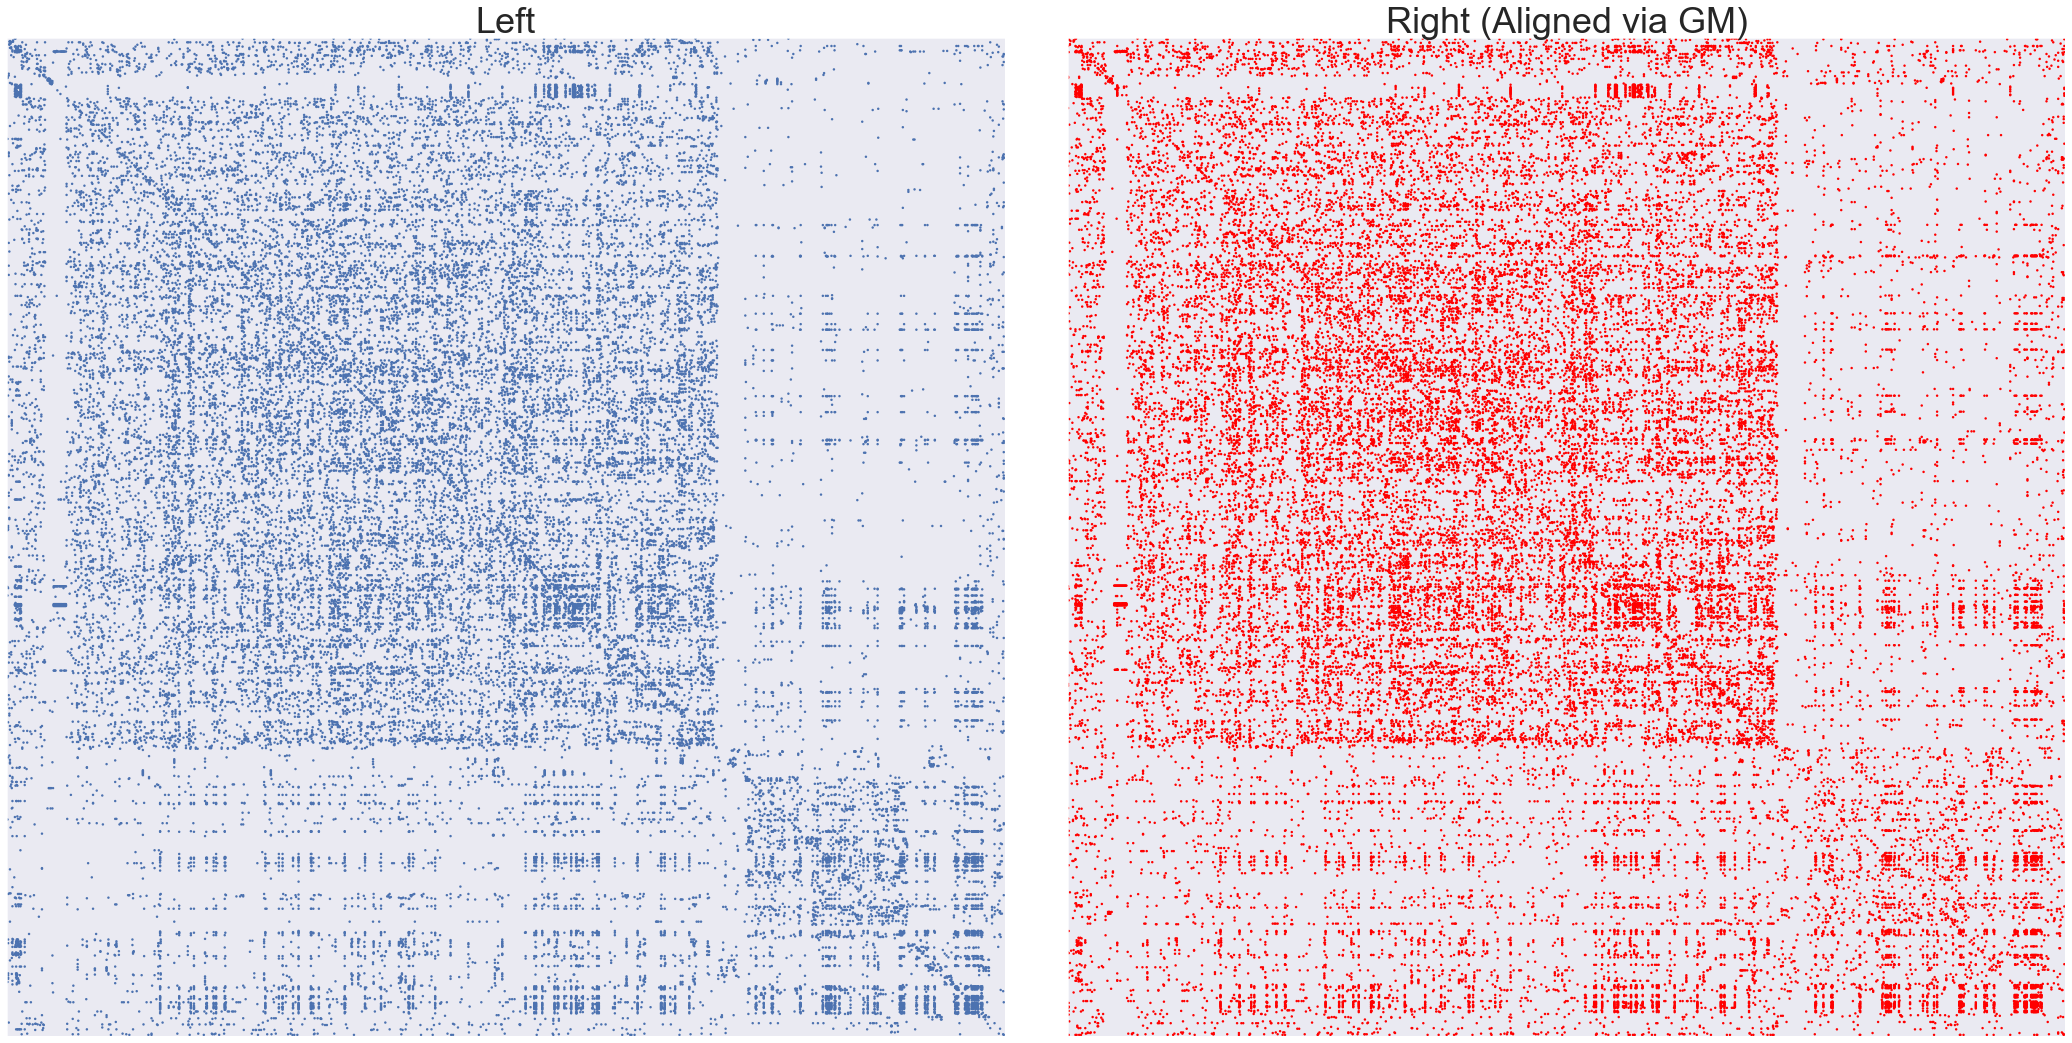

In [18]:
right_adj_us = right_adj[res.col_ind][:,res.col_ind]
plot_connectome(left_adj, right_adj_us)


In [21]:
len(n_pairs)

TypeError: object of type 'int' has no len()

In [23]:
n_pairs = 1161
# sum(res.col_ind[:n_pairs] == np.arange(n_pairs))/n_pairs
sum(res.col_ind == np.arange(n_pairs))/n_pairs

0.8148148148148148

In [120]:
print(res)

 col_ind: array([   0,    1,    2, ..., 1158, 1159, 1111])
     fun: 823050.0
     nit: 30


In [ ]:
def eval(test_pairs, m1_words, m2_words, P):
    num_correct = 0
    total = 0
    for test_pair in test_pairs:
        m1_word, m2_word = test_pair.split()
        m1_pos = m1_words.get(m1_word)
        m2_pos = m2_words.get(m2_word)
        if m1_pos and m2_pos and P[m1_pos] == m2_pos:
            print('Match:', m1_word, m2_word)
            num_correct += 1
        total += 1
    return (num_correct, total)

